## Kalman filtering of linear system

In [1]:
%pylab
%matplotlib inline


Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [2]:
from numpy.linalg import inv
from numpy.random import multivariate_normal


Before going into much detail about the filter itself let's see what it does. Consider a simple linear dynamical system which, for instance, may be taken as representing the position and velocity of a mass on a spring:

\begin{equation}
\begin{aligned}
\dot y_1 &= -2\,y_1 + 2\,y_2 + 1\\
\dot y_2 &= -4\,y_1 + 2\,y_2
\end{aligned}
\end{equation}

The system has an analytical solution (plotted below):
\begin{equation}
\begin{aligned}
%y_1 &= \frac{3\,\sin{2\,t} + 3\,\cos{2\,t} -1}{2}
y_1 &= 1.5\,\sin{2\,t} + 1.5\,\cos{2\,t} - 0.5
\\
y_2 &= 3\,\cos{2\,t} - 1
\end{aligned}
\end{equation}



Text(0.5,0,u't')

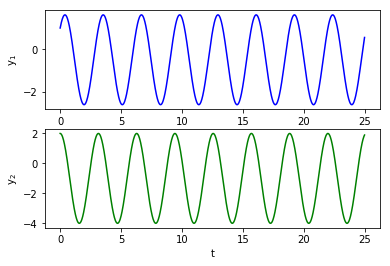

In [3]:
t = np.linspace(start=0.,stop=25.,num=1000)

#analytical solution
yan1 = (3*np.sin(2*t) + 3*np.cos(2*t) -1)/2
yan2 = 3*np.cos(2*t) - 1

plt.subplot(2,1,1)
plt.plot(t,yan1,'b')
plt.ylabel(r'y$_1$')

plt.subplot(2,1,2)
plt.plot(t,yan2,'g')
plt.ylabel(r'y$_2$')
plt.xlabel('t')

# savefig('Figures/analytical_solution.pdf')

Note that the analytical solution can be verified via numerical integration:

In [4]:
from scipy.integrate import odeint

Text(0.5,0,u't')

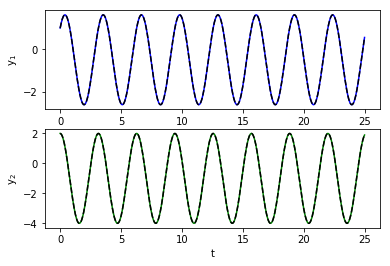

In [5]:
A = np.array([ [-2.,2.],[-4.,2.] ])
u = np.array([1.,0.]) #note dim of u
y0 = np.array([1.,2.]) #and y0

def odefunc(y, t):
    dydt = A.dot(y) + u
    return dydt

y_num = odeint(odefunc, [1,2], t)
ynum1, ynum2 = y_num[:,0],y_num[:,1]

plt.subplot(2,1,1)
plt.plot(t,yan1,'b',t,ynum1,'--k')
plt.ylabel(r'y$_1$')
plt.subplot(2,1,2)
plt.plot(t,yan2,'g',t,ynum2,'--k')
plt.ylabel(r'y$_2$')
plt.xlabel('t')

Let us further assume that our model of the system is imperfect. There are non-linearities in the spring, there is air resistance, wind, and a myriad of other un-accounted for effects that result in a noisy outcome. If these effects are uncorrelated then their sum total will have a Gaussian probability distribution. We can represent this uncertainty by adding noise to our initial value and then at every simulation step to the dynamical system. Note that now the system does not belong anymore to the familiar deterministic systems we are used to working with, but rather is now stochastic. Each time the system is simulated (each realization) the result will be different, and this randomness is an inherent characteristic of the system, so that no amount of numerical improvement (reduction in step size, etc.) can result in a more accurate output. For non-linear systems the individual realizations may be wildly different from each other. Nonetheless, for linear systems, the statistical properties of the stochastic system are guaranteed to converge to those of the analytical solution, that is the mean of the ensemble at any time should converges to the true mean. 


In [7]:
import sdeint
from numpy.random import multivariate_normal

In [8]:
Q = np.array([[1e-1, 0],[0, 1e-1]])
P = np.array([[0.1, 0],[0, 0.1]])

ystoch = []
for i in range(25):
    
    x0 = np.array([1.0, 2.0]) + multivariate_normal([0,0],P)

    def f(x, t):
        return A.dot(x) + u

    def G(x, t):
        return Q

    result = sdeint.itoint(f, G, x0, t)

    ystoch.append(result)



In [9]:
len(ystoch)

25

/usr/local/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


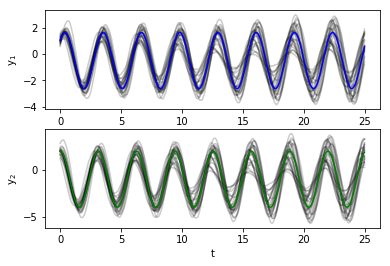

In [10]:
# plt.hold(True)
for i in range(25):
    plt.subplot(2,1,1)
    plt.plot(t,ystoch[i][:,0],'k',alpha=0.2)
    plt.ylabel(r'y$_1$')
    plt.subplot(2,1,2)
    plt.plot(t,ystoch[i][:,1],'k',alpha=0.2)
    plt.ylabel(r'y$_2$')
    plt.xlabel('t')

plt.subplot(2,1,1).plot(t,yan1,'b')
plt.subplot(2,1,2).plot(t,yan2,'g')

# savefig('Figures/stoch_system.pdf')

A second source of uncertainty may come from our observations which may themselves be imprecise, for instance, as geochemists are well aware, repeated weighing of a small amount of material will inevitably result in slightly different values, though the amount of material being weighed remains constant. If the sources of error are uncorrelated then this uncertainty too can be represented by a noise term with a Gaussian distribution which acts to blur the true (analytical) solution. 

In [11]:
#make the observations be the analytical solution plus noise
yan = np.vstack(([yan1],[yan2])).T
R = np.array([[1., 0],[0, 1.]])
z = yan + multivariate_normal([0,0],R,len(t))

Text(0.5,0,u't')

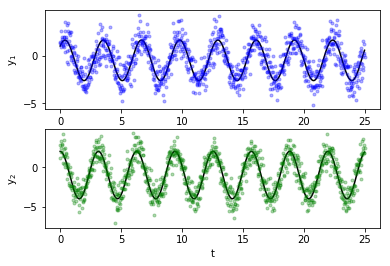

In [12]:
n = 25 #plot every nth point for visibility
plt.subplot(2,1,1)
plt.plot(t,yan1,'k')
plt.plot(t,z[:,0],'b.',alpha=0.3)
plt.ylabel(r'y$_1$')

plt.subplot(2,1,2)
plt.plot(t,yan2,'k')
plt.plot(t,z[:,1],'g.',alpha=0.3)
plt.ylabel(r'y$_2$')
plt.xlabel('t')

# savefig('Figures/data.pdf')

The question is then, given these uncertainties can one recover a precise estimate of the states of the system? The Kalman filter does precisely that, and, for linear systems and Gaussian noise, is guaranteed to provide an estimate that is as close as possible to the true (analytical) solution, and is better than either model or observations alone. 

Text(0.5,0,u't')

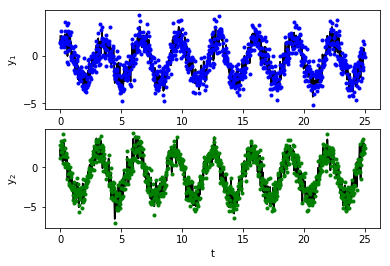

In [13]:
#now for the filter proper
x = y0
xs_own, cov = [], []
H = np.eye(2)
dt = t[1] - t[0]
F = np.eye(2) + dt*A

for i in range(0,len(t)):
    #predict step
    x = dot(F,x) + dt*u
    P = dot(A,P).dot(A.T) + Q
    
    #update
    S = dot(H, P).dot(H.T) + R
    K = dot(P, H.T).dot(inv(S))
    y = z[i,:].reshape((2,1)) - dot(H, x)
    x = x + dot(K, y)
    P = P - dot(K, H).dot(P)
    
    xs_own.append(x)
    cov.append(P)
    
    
xs_own, cov = np.array(xs_own), np.array(cov)

plt.subplot(2,1,1)
plt.plot(t,xs_own[:,0],'k',t,z[:,0],'b.')
plt.ylabel(r'y$_1$')
plt.subplot(2,1,2)
plt.plot(t,xs_own[:,1],'k',t,z[:,1],'g.')
plt.ylabel(r'y$_2$')
plt.xlabel('t')


In [14]:
#Compare with the pyFilter implementation

In [16]:
from filterpy.kalman import predict, update
from filterpy.kalman import KalmanFilter

Text(0.5,0,u't')

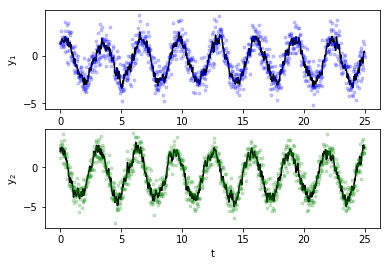

In [17]:

kf = KalmanFilter(dim_x=2, dim_z=2, dim_u = 2)
kf.x = y0 # location and velocity
kf.F = F
kf.H = H
kf.R = R
kf.P = P
kf.Q = Q


# run the kalman filter and store the results
xs, cov = [], []
for i in range(0,len(t)):
    kf.predict()
    kf.update(z[i,:])
    xs.append(kf.x)
    cov.append(kf.P)

xs, cov = np.array(xs), np.array(cov)

#the filter plotted with the noisy data
plt.subplot(2,1,1)
plt.plot(t,xs[:,0],'k')
plt.plot(t,z[:,0],'.b',alpha=0.2)
plt.ylabel(r'y$_1$')
plt.subplot(2,1,2)
plt.plot(t,xs[:,1],'k')
plt.plot(t,z[:,1],'.g',alpha=0.2)
plt.ylabel(r'y$_2$')
plt.xlabel('t')
# savefig('Figures/filter_data.pdf')

Text(0.5,0,u't')

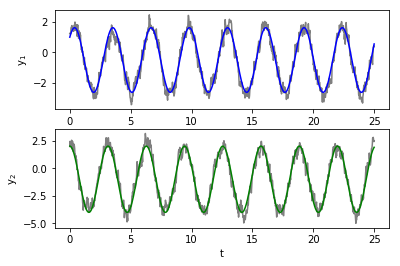

In [18]:
#the filter plotted against the analytical solution
plt.subplot(2,1,1)
plt.plot(t,xs[:,0],'k',alpha=0.5)
plt.plot(t,yan1,'b')
plt.ylabel(r'y$_1$')
plt.subplot(2,1,2)
plt.plot(t,xs[:,1],'k',alpha=0.5)
plt.plot(t,yan2,'g')
plt.ylabel(r'y$_2$')
plt.xlabel('t')


# savefig('Figures/filter_analytical.pdf')

the pyfilt implementation is smoother than mine why I do not know...

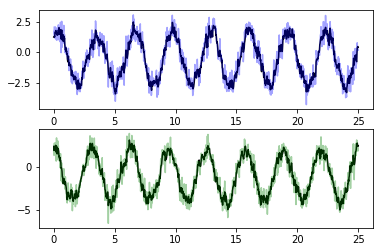

In [19]:
plt.subplot(2,1,1)
plt.plot(t,xs[:,0],'k')
plt.plot(t,xs_own[:,0],'b',alpha=0.2)
plt.subplot(2,1,2)
plt.plot(t,xs[:,1],'k')
plt.plot(t,xs_own[:,1],'g',alpha=0.2)

### Apply RTS smoother

In [ ]:
# smoother gain
nn, dim_x = xs.shape
K = zeros((nn,dim_x, dim_x))
x, PP = xs.copy(), cov.copy()


for k in range(nn-2,-1,-1):
    P_pred = dot(F, PP[k]).dot(F.T) + Q

    K[k]  = dot(PP[k], F.T).dot(inv(P_pred))
    x[k] += dot(K[k], x[k+1] - dot(F, x[k]))
    PP[k] += dot(K[k], PP[k+1] - P_pred).dot(K[k].T)

In [ ]:

plt.subplot(2,1,1)
plt.plot(t,x[:,0],'k')
plt.plot(t,yan1,'g')
plt.subplot(2,1,2)
plt.ylabel(r'y$_1$')
plt.plot(t,x[:,1],'k')
plt.plot(t,yan2,'b')
plt.ylabel(r'y$_2$')
plt.xlabel('t')

# savefig('Figures/RTS_analytical.pdf')

In [ ]:
plt.figure(figsize = (6, 6))
for i in range(25):
    plt.subplot(2,1,1)
    plt.plot(t,ystoch[i][:,0],'g',alpha=0.2)
#     plt.ylabel(r'y$_1$')
    plt.subplot(2,1,2)
    plt.plot(t,ystoch[i][:,1],'b',alpha=0.2)
#     plt.ylabel(r'y$_2$')
#     plt.xlabel('t')



plt.subplot(2,1,1)
plt.plot(t,z[:,0],'.g',alpha=0.2)
# plt.plot(t,yan1,'g')
plt.plot(t,x[:,0],'k')
# plt.errorbar(t,x[:,0],yerr=sqrt(Pvar),capsize=0,ls='none')
plt.ylabel(r'y$_1$')

plt.subplot(2,1,2)
plt.plot(t,z[:,1],'.b',alpha=0.2)
# plt.plot(t,yan2,'b')
plt.plot(t,x[:,1],'k')
# plt.errorbar(t,x[:,1],yerr=sqrt(Pvar),capsize=0,ls='none')

plt.ylabel(r'y$_2$')
plt.xlabel('t')
# 
# savefig('Figures/RTS_stoch_data.pdf')

Plot the errors alongside the filter

In [ ]:
Pvar = PP[:,0,0]

In [ ]:
# plt.figure(figsize = (16, 6))
# plt.plot(t[0::n],x[0::n,0],'k',t,yan1,'g')
# plt.fill_between(t,x[:,0]+sqrt(Pvar),x[:,0]-sqrt(Pvar))
plt.errorbar(t,x[:,0],yerr=sqrt(Pvar),capsize=0,ls='none')
plt.plot(t,x[:,0],'k')
plt.plot(t,z[:,0],'o',alpha=0.2)
# plt.plot(t[0:100],yan1[0:100],'b')


Is the RTS smoother in fact smoother than the Kalman filter?

In [ ]:
plt.subplot(2,1,1)
plt.plot(t,x[:,0],'k')
plt.plot(t,xs[:,0],'g',alpha=0.3)
plt.subplot(2,1,2)
plt.plot(t,x[:,1],'k')
plt.plot(t,xs[:,1],'b',alpha=0.3)

## Now for parameter estimation

In [ ]:
kf = KalmanFilter(dim_x=3, dim_z=2, dim_u = 3)
kf.x = np.array([[1],[2],[5]]) # location and velocity
kf.F = np.eye(3) + dt*np.array([[-2., 2., 1.],[-4.,  2., 0],[0,0,0]])  
kf.H = np.array([[1., 0, 0],[0, 1, 0]])    
kf.R = [[1., 0],[0, 1.]]                     
kf.P = np.array([[0.1, 0, 0],[0, 0.1, 0],[0, 0, 0.1]])
kf.Q = np.array([[1e-1, 0, 0],[0, 1e-1, 0],[0, 0, 1e-2]])


# run the kalman filter and store the results
xs, cov = [], []
for i in range(0,len(t)):
    kf.predict()
    kf.update(z[i,:].reshape((2,1)))
    xs.append(kf.x)
    cov.append(kf.P)

xs, cov = np.array(xs), np.array(cov)

In [ ]:
plt.subplot(3,1,1)
plt.plot(t,xs[:,0],'k',t,z[:,0],'.b')
plt.subplot(3,1,2)
plt.plot(t,xs[:,1],'k',t,z[:,1],'.g')
plt.subplot(3,1,3)
plt.plot(t,xs[:,2])


now also use smoother for parameter estimation

In [ ]:

nn, dim_x, _ = xs.shape
K = zeros((nn,dim_x, dim_x))
x, P = xs.copy(), cov.copy()
F = kf.F
Q = kf.Q

for k in range(nn-2,-1,-1):
    P_pred = dot(F, P[k]).dot(F.T) + Q

    K[k]  = dot(P[k], F.T).dot(inv(P_pred))
    x[k] += dot(K[k], x[k+1] - dot(F, x[k]))
    P[k] += dot(K[k], P[k+1] - P_pred).dot(K[k].T)

In [ ]:
plt.figure(figsize = (6, 6))
plt.subplot(3,1,1)
plt.plot(t,x[:,0],'k')
plt.plot(t,z[:,0],'.g',alpha=0.2)
plt.plot(t,yan1,'g')
plt.ylabel(r'y$_1$')

plt.subplot(3,1,2)
plt.plot(t,x[:,1],'k')
plt.plot(t,z[:,1],'.b',alpha=0.2)
plt.plot(t,yan2,'b')
plt.ylabel(r'y$_2$')

plt.subplot(3,1,3)
plt.plot(t,x[:,2],'k')
plt.ylabel(r'a')
plt.xlabel('t')

# savefig('Figures/RTS_Pest.pdf')

## Uncented Filter

In [ ]:
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.kalman import MerweScaledSigmaPoints

In [ ]:

points = MerweScaledSigmaPoints(n=3, alpha=.3, beta=2., kappa=.1)

def f_cv(x):
    return np.dot(F, x)

def h_cv(x):
    return np.dot(H,x)

ukf = UKF(dim_x=3, dim_z=2, dt=dt, fx=f_cv, hx=h_cv, points=points)

ukf.x = np.array([[1],[2],[5]]) # location and velocity
ukf.F = np.eye(3) + dt*np.array([[-2., 2., 1.],[-4.,  2., 0],[0,0,0]])  
ukf.H = np.array([[1., 0, 0],[0, 0, 0]])    
ukf.R = [[1., 0],[0, 1.]]                     
ukf.P = np.array([[0.1, 0, 0],[0, 0.1, 0],[0, 0, 0.1]])
ukf.Q = np.array([[1e-1, 0, 0],[0, 1e-1, 0],[0, 0, 1e-2]])

# run the kalman filter and store the results
xs, covs = [], []
for i in range(0,len(t)):
    kf.predict()
    kf.update(z[i,:].reshape(2,1))
    xs.append(kf.x)
    covs.append(kf.P)

xs, covs = np.array(xs), np.array(covs)

#the filter plotted with the noisy data
plt.figure(figsize = (6, 6))
plt.subplot(3,1,1)
plt.plot(t,x[:,0],'k')
plt.plot(t,z[:,0],'.g',alpha=0.2)
plt.plot(t,yan1,'g')
plt.ylabel(r'y$_1$')

plt.subplot(3,1,2)
plt.plot(t,x[:,1],'k')
plt.plot(t,z[:,1],'.b',alpha=0.2)
plt.plot(t,yan2,'b')
plt.ylabel(r'y$_2$')

plt.subplot(3,1,3)
plt.plot(t,x[:,2],'k')
plt.ylabel(r'a')
plt.xlabel('t')
# savefig('Figures/filter_data.pdf')

In [ ]:
Ms, P, K = kf.rts_smoother(xs, covs)

plt.figure(figsize = (6, 6))
plt.subplot(3,1,1)
plt.plot(t,Ms[:,0],'k')
plt.plot(t,z[:,0],'.g',alpha=0.2)
plt.plot(t,yan1,'g')
plt.ylabel(r'y$_1$')

plt.subplot(3,1,2)
plt.plot(t,Ms[:,1],'k')
plt.plot(t,z[:,1],'.b',alpha=0.2)
plt.plot(t,yan2,'b')
plt.ylabel(r'y$_2$')

plt.subplot(3,1,3)
plt.plot(t,Ms[:,2],'k')
plt.ylabel(r'a')
plt.xlabel('t')




## Ensemble Kalman Filter

In [ ]:
#create an ensemble of perturbed initial states 
mean = y0.flatten()
cov = Pnp.array([[0.01, 0, 0],[0, 0.01, 0], [0, 0, .1]])
x = np.random.multivariate_normal(mean, cov, 100).T

In [ ]:
Cs = []
xs = []
for i in range(0,len(t)):
    #predict step
    x = x + (dot(A,x) + u)*dt
    P = dot(A,P).dot(A.T) + Q
#     print P.shape
    #create an ensemble of perturbed data (need to do this for each timestep)
    z_mean = z[:,0].flatten()
    z_cov = np.array([[0.01, 0],[0, 0.01]])
    z = np.random.multivariate_normal(z_mean, z_cov, 100).T

    C = np.cov(x)
    

    # x = x + C*H.T*(H*C*H.T + R)^-1*(D - H*X)
    S = dot(H, C).dot(H.T) + R
    K = dot(C, H.T).dot(inv(S))
    y = z - dot(H, x)
    x = x + dot(K, y)

    x_mean = x.mean(axis=1)
    xs.append(x_mean)
    Cs.append(C)
    
xs, cov = np.array(xs), np.array(cov)

In [ ]:
plt.subplot(2,1,1)
plt.plot(t,xs[:,0],t,yan1)
plt.subplot(2,1,2)
plt.plot(t,xs[:,1],t,yan2)

